In [1]:
# For system modeling and simulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import colorsys
import math
from queue import PriorityQueue
import copy
import matplotlib.patches as patches

# For getting results related to run time and memory usage
import time
import tracemalloc

# For the barrier GUI
import tkinter as tk
from tkinter import simpledialog, messagebox
import json

# For sending code to Arduino
import serial
import time

# For taking screenshots and exporting to pdf
from PIL import Image
import os
import pyautogui
from matplotlib.gridspec import GridSpec

In [2]:
# Define the four possible actions
actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left

In [3]:
class AccessPoint:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.used = False

    def get_rssi(self, x, y, interference, multipath, attenuation,max_distance,n):
        distance = math.sqrt((self.x - x) ** 2 + (self.y - y) ** 2)
        if distance> math.sqrt((2*max_distance)** 2):
            distance = math.sqrt((2*max_distance)** 2)
        path_loss = -10 *n* math.log10(distance) if distance != 0 else 0
        rssi= path_loss - interference - multipath - attenuation
        
        if rssi>-30:
            rssi=-30
        elif rssi<-90:
            rssi=-90
        return rssi 

In [4]:
class Customer:
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [5]:
class Product:
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [6]:
def create_access_points(n_x, n_y, max_distance):
    
    access_points = []
    
    interval_x = max_distance / (n_x-1)
    interval_y = max_distance / (n_y-1)

    
    for i in range(n_x):
        for j in range(n_y):
            access_points.append(AccessPoint(i*interval_x, j*interval_y))
    
    return access_points

In [7]:
def trilateration(access_points, ap_indices, distances,max_distance):
    A = np.zeros((3, 2))
    b = np.zeros((3, 1))

    for i in range(3):
        A[i][0] = 2 * (access_points[ap_indices[i]].x - access_points[ap_indices[0]].x)
        A[i][1] = 2 * (access_points[ap_indices[i]].y - access_points[ap_indices[0]].y)
        b[i] = (distances[0] ** 2) - (distances[i] ** 2) + (access_points[ap_indices[i]].x ** 2) - (access_points[ap_indices[0]].x ** 2) + (access_points[ap_indices[i]].y ** 2) - (access_points[ap_indices[0]].y ** 2)

    x, y = np.linalg.lstsq(A, b, rcond=None)[0]
    
   # limiting space in board  
    if x<0:
        x=0+1
    elif x>max_distance:
        x=max_distance-1
        
    if y<0:
        y=0+1
    elif y>max_distance:
        y=max_distance-1

    return x, y

In [8]:
def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

In [9]:
# Made the grid smaller compared to try15
class BarrierApp:
    def __init__(self, n_x, n_y, max_distance):
        
        # Defining the variables needed to make the GUI
        self.n_x = n_x + 1  # Incremented by 1 to include the final index
        self.n_y = n_y + 1  # Incremented by 1 to include the final index
        self.max_distance = max_distance
        self.barrier = []
        
        # Creating the GUI Window
        self.root = tk.Tk()
        self.root.title("Barrier Input")
        self.canvas = tk.Canvas(self.root, width=self.n_x * 8 + 20, height=self.n_y * 8 + 20)
        self.canvas.pack()
        
        # Creating the GUI window clicks. 1 click means select and 2 clicks mean unselect
        self.canvas.bind("<Button-1>", self.set_barrier)
        self.canvas.bind("<Double-1>", self.unset_barrier)
        self.setup_grid()
        
        # Creating the GUI buttons. Clicking on close will also generate screenshot
        self.done_button = tk.Button(self.root, text="Done", command=self.done)
        self.done_button.pack()

        self.close_button = tk.Button(self.root, text="Close", command=self.close_app)
        self.close_button.pack()

    def setup_grid(self):
        for i in range(self.n_x + 1):
            self.canvas.create_line(i * 8 + 20, 20, i * 8 + 20, self.n_y * 8 + 20, fill="gray")
            if i % 5 == 0:
                self.canvas.create_text(i * 8 + 20, self.n_y * 8 + 30, text=str(i), fill="black")

        for j in range(self.n_y + 1):
            self.canvas.create_line(20, j * 8 + 20, self.n_x * 8 + 20, j * 8 + 20, fill="gray")
            if j % 5 == 0:
                self.canvas.create_text(10, (self.n_y - j) * 8 + 20, text=str(j), fill="black")

    def set_barrier(self, event):
        x = (event.x - 20) // 8
        y = self.n_y - 1 - (event.y - 20) // 8

        if [x, y] not in self.barrier and 0 <= x < self.n_x and 0 <= y < self.n_y:
            self.barrier.append([x, y])
            self.canvas.create_rectangle(x * 8 + 20, (self.n_y - y - 1) * 8 + 20, (x + 1) * 8 + 20, (self.n_y - y) * 8 + 20, fill="red")

    def unset_barrier(self, event):
        x = (event.x - 20) // 8
        y = self.n_y - 1 - (event.y - 20) // 8

        if [x, y] in self.barrier:
            self.barrier.remove([x, y])
            self.canvas.create_rectangle(x * 8 + 20, (self.n_y - y - 1) * 8 + 20, (x + 1) * 8 + 20, (self.n_y - y) * 8 + 20, fill="white")
            self.canvas.create_line(x * 8 + 20, (self.n_y - y - 1) * 8 + 20, (x + 1) * 8 + 20, (self.n_y - y - 1) * 8 + 20, fill="gray")
            self.canvas.create_line((x + 1) * 8 + 20, (self.n_y - y - 1) * 8 + 20, (x + 1) * 8 + 20, (self.n_y - y) * 8 + 20, fill="gray")
            self.canvas.create_line(x * 8 + 20, (self.n_y - y) * 8 + 20, (x + 1) * 8 + 20, (self.n_y - y) * 8 + 20, fill="gray")
            self.canvas.create_line(x * 8 + 20, (self.n_y - y - 1) * 8 + 20, x * 8 + 20, (self.n_y - y) * 8 + 20, fill="gray")

    def done(self):
        self.root.quit()
        self.root.destroy()

    def close_app(self):
        self.root.after(500, self.save_plot_as_pdf)  # Delay to ensure the screenshot is taken
        self.root.after(1000, self.done)
        
    def save_plot_as_pdf(self):
        fig, ax = plt.subplots(figsize=(self.n_x / 10, self.n_y / 10))
        ax.scatter([x[0] for x in self.barrier], [x[1] for x in self.barrier], color='red', marker='s')
        ax.grid(which='both')
        ax.set_xlim(0, self.n_x - 1)
        ax.set_ylim(0, self.n_y - 1)

        # Set major and minor tick intervals to match the GUI
        ax.set_xticks(range(0, self.n_x, 10))
        ax.set_yticks(range(0, self.n_y, 10))
        ax.set_xticks(range(0, self.n_x), minor=True)
        ax.set_yticks(range(0, self.n_y), minor=True)
        
        # Ensure the aspect ratio matches the GUI layout
        ax.set_aspect('equal', adjustable='box')

        # Set the spines to match the actual axis lines
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')

        fig.savefig("barrier_grid.pdf", format='pdf')
        plt.close(fig)

    def run(self):
        self.root.mainloop()
        return self.barrier


In [10]:
def get_barrier(n_x, n_y, max_distance):
    file_name = 'barrier_data.json'

    user_choice = input("Enter 1 to create a new barrier environment or 2 to load from a previous one: ")

    if user_choice == '1':  # Create new barrier environment
        app = BarrierApp(n_x ** 2, n_y ** 2, max_distance)
        barriers = app.run()
        with open(file_name, 'w') as file:
            json.dump(barriers, file)
    elif user_choice == '2':  # Load previous barrier environment
        if os.path.exists(file_name):
            with open(file_name, 'r') as file:
                barriers = json.load(file)
        else:
            print("No previous barrier environment found. Creating a new one.")
            app = BarrierApp(n_x ** 2, n_y ** 2, max_distance)
            barriers = app.run()
            with open(file_name, 'w') as file:
                json.dump(barriers, file)
    else:
        print("Invalid input. Creating a new barrier environment by default.")
        app = BarrierApp(n_x ** 2, n_y ** 2, max_distance)
        barriers = app.run()
        with open(file_name, 'w') as file:
            json.dump(barriers, file)

    return barriers

In [11]:
def is_barrier(barrier, pos):
    return pos in barrier

In [12]:
def get_neighbor_nodes(pos,n_x,n_y,barrier,actions,max_distance):
        neighbors=[]
        neighbor_dir={}
        actions_mapping = ['u', 'r', 'd', 'l']
        
        # 1st check condition is to always check if we are going beyond the grid
        #2nd is the positional check
        #added as neighbor if the conditions match (inside the grid and not a barrier)
        
        # checking the grid right above current grid pos and making it neighbor if not barrier
        if pos[1]< max_distance - 1 and not is_barrier(barrier,[pos[0],pos[1]+1]):
            neighbors.append([pos[0] + actions[0][0],pos[1] + actions[0][1]])
            neighbor_dir[(pos[0] + actions[0][0],pos[1] + actions[0][1])]=actions_mapping[0]
            
        # checking the grid right below current grid pos and making it neighbor if not barrier   
        if pos[1] > 0 and not is_barrier(barrier,[pos[0],pos[1]-1]):
            neighbors.append([pos[0] + actions[2][0],pos[1] + actions[2][1]])
            neighbor_dir[(pos[0] + actions[2][0],pos[1] + actions[2][1])]=actions_mapping[2]
        
        # checking the right neighbor of current grid pos and making it neighbor if not barrier
        if pos[0] < max_distance - 1 and not is_barrier(barrier,[pos[0] + 1,pos[1]]):
            neighbors.append([pos[0] + actions[1][0],pos[1] + actions[1][1]])
            neighbor_dir[(pos[0] + actions[1][0],pos[1] + actions[1][1])]=actions_mapping[1]
            
        # checking the left neighbor of current grid pos and making it neighbor if not barrier
        if pos[0] > 0 and not is_barrier(barrier,[pos[0] - 1,pos[1]]):
            neighbors.append([pos[0] + actions[3][0],pos[1] + actions[3][1]])
            neighbor_dir[(pos[0] + actions[3][0],pos[1] + actions[3][1])]=actions_mapping[3]
            
        return neighbors, neighbor_dir


In [13]:
def make_board(max_distance):
    
    board = [[0]*(max_distance+1)]*(max_distance+1)
    g_score= {}
    f_score= {}
    
    for i in range(max_distance+1):
        for j in range(max_distance+1):
            g_score[(i,j)]=float("inf")
            g_score[(i,j)]=float("inf")

    return board,g_score,f_score

In [14]:
def print_and_write(f, message):
    print(message)
    f.write(message + "\n")

In [15]:
def print_sim_results(access_points, all_rssi, all_near_aps, all_coordinate, all_distances, prod_num, current, peak, filename):
    # Open a file to write the results
    with open(filename, "w") as f:
        # Print and write the results to the file
        print_and_write(f, "Simulation Results:")
        print_and_write(f, "------------------")
        print_and_write(f, "Customer start coordinates:")
        print_and_write(f, "    X: {}".format(int(all_coordinate[0])))
        print_and_write(f, "    Y: {}".format(int(all_coordinate[1])))

        for i in range(2, len(all_coordinate) - 2, 2):
            print_and_write(f, f"Product {prod_num} coordinates:")
            print_and_write(f, "    X: {}".format(int(all_coordinate[i])))
            print_and_write(f, "    Y: {}".format(int(all_coordinate[i + 1])))
            prod_num += 1

        prod_num = 1
        print_and_write(f, "Counter coordinates:")
        print_and_write(f, "    X: {}".format(int(all_coordinate[-2])))
        print_and_write(f, "    Y: {}".format(int(all_coordinate[-1])))

        print_and_write(f, "Customer nearest APs coordinates and Respective RSSI:")
        for i, ap_index in enumerate(all_near_aps[:3]):
            print_and_write(f, "    AP {}: {}".format(i + 1, (access_points[ap_index].x, access_points[ap_index].y)))
            print_and_write(f, "    RSSI of AP {}: {}".format(i + 1, all_rssi[i]))

        for i in range(3, len(all_near_aps) - 3, 3):
            print_and_write(f, f"Product {prod_num} nearest APs coordinates and Respective RSSI:")
            for j, ap_index in enumerate(all_near_aps[i:i + 3]):
                print_and_write(f, "    AP {}: {}".format(j + 1, (access_points[ap_index].x, access_points[ap_index].y)))
                print_and_write(f, "    RSSI of AP {}: {}".format(j + 1, all_rssi[i + j]))
            prod_num += 1

        prod_num = 1

        print_and_write(f, "Counter nearest APs coordinates and Respective RSSI:")
        for i, ap_index in enumerate(all_near_aps[-3:]):
            print_and_write(f, "    AP {}: {}".format(i + 1, (access_points[ap_index].x, access_points[ap_index].y)))
            print_and_write(f, "    RSSI of AP {}: {}".format(i + 1, all_rssi[-3 + i]))

        print_and_write(f, "Customer distances:")
        for i, distance in enumerate(all_distances[:3]):
            print_and_write(f, "    AP {}: {}".format(i + 1, distance))

        for i in range(3, len(all_distances) - 3, 3):
            print_and_write(f, f"Product {prod_num} distances:")
            for j, distance in enumerate(all_distances[i:i + 3]):
                print_and_write(f, "    AP {}: {}".format(j + 1, distance))
            prod_num += 1

        prod_num = 1

        print_and_write(f, "Counter distances:")
        for i, distance in enumerate(all_distances[-3:]):
            print_and_write(f, "    AP {}: {}".format(i + 1, distance))
        
        print_and_write(f, f"Current memory usage: {current / 10**6} MB")
        print_and_write(f, f"Peak memory usage: {peak / 10**6} MB")

In [16]:
def make_inputs(barriers, max_distance, map_type):
    file_name = 'product_data.json'

    user_choice = input("Enter 1 to create new products or 2 to load from a previous file: ")

    inp_coordinates = []

    if user_choice == '2' and os.path.exists(file_name):
        with open(file_name, 'r') as file:
            data = json.load(file)
            inp_coordinates = data['coordinates']
            num_prod = data['num_prod']
    else:
        num_prod = int(input("Enter the number of products you want to put: "))

        start1_x = 50
        start1_y = 10
        end1_x = 50
        end1_y = 90
        start2_x = 20
        start2_y = 10
        end2_x = 45
        end2_y = 80

        if map_type == 0:
            for i in range(num_prod + 2):
                while True:
                    px = np.random.randint(0, max_distance)
                    py = np.random.randint(0, max_distance)
                    if not is_barrier(barriers, [px, py]):
                        inp_coordinates.append([px, py])
                        break
        else:
            if map_type == 1:
                inp_coordinates.append([start1_x, start1_y])
            elif map_type == 2 or map_type == 3:
                inp_coordinates.append([start2_x, start2_y])
            for i in range(num_prod):
                while True:
                    px = np.random.randint(0, max_distance)
                    py = np.random.randint(0, max_distance)
                    if not is_barrier(barriers, [px, py]):
                        inp_coordinates.append([px, py])
                        break
            if map_type == 1:
                inp_coordinates.append([end1_x, end1_y])
            elif map_type == 2 or map_type == 3:
                inp_coordinates.append([end2_x, end2_y])

        with open(file_name, 'w') as file:
            json.dump({'coordinates': inp_coordinates, 'num_prod': num_prod}, file)

    return inp_coordinates, num_prod

In [17]:
def make_distinct_colors(num_colors_needed):
    # Divide the hue spectrum into equal parts to ensure distinct colors
    hue_step = 1.0 / num_colors_needed
    colors = []

    for i in range(num_colors_needed):
        hue = i * hue_step
        saturation = 0.7 + random.random() * 0.2  # Saturation between 0.7 and 0.9
        lightness = 0.5 + random.random() * 0.3   # Lightness between 0.5 and 0.8
        r, g, b = colorsys.hls_to_rgb(hue, lightness, saturation)
        colors.append((r, g, b))

    return colors

In [18]:
def load_or_generate_colors(num_colors_needed):
    choice = input("Enter 1 to create new colors or 2 to load from a previous file: ")
    
    if choice == '2':
        try:
            with open('colors.json', 'r') as file:
                saved_colors = json.load(file)
                if len(saved_colors) >= num_colors_needed:
                    return saved_colors[:num_colors_needed]
                else:
                    print(f"Saved file has only {len(saved_colors)} colors. Generating additional colors.")
                    additional_colors = make_distinct_colors(num_colors_needed - len(saved_colors))
                    return saved_colors + additional_colors
        except FileNotFoundError:
            print("Saved color file not found. Generating new colors instead.")

    # Generate the required number of distinct colors
    colors = make_distinct_colors(num_colors_needed)

    # Save the generated colors for future use
    with open('colors.json', 'w') as file:
        json.dump(colors, file)

    return colors

In [19]:
def reconstruct_path(came_from,current):
    
    opt_path=[]
    #transversing through the path
    while current in came_from:
        current = came_from[current]
        opt_path.append((current))
    opt_path.reverse()
    cost=len(opt_path)
    last_coordinates = tuple(opt_path[-1])
    return opt_path,cost, last_coordinates

In [20]:
# the a* algorithm
def aStar(max_distance,n_x,n_y,board,g_score,f_score, start, end, barrier):
    
    # Record the start time of algorithm
    full_algo_start_time = time.time()
    
    
    # used to track when items are inserted in queue
    # could also be used to select the first entry if fscore is same (breaking tie in scores)
    count = 0 
    
    direction = 'x'
    
    
    
    #open set will contain values of nodes that were neighbors but not chosen for transversing
    #PriorityQueue() fnc returns the smallest element(smallest fscore element) using the heapsort algo
    open_set = PriorityQueue() # here we can add or delete but cannot check items present
    
    # add start to priority queue and initial fscore is set at 0
    open_set.put((0, count, start))
    
    #closed set value that stores pos of nodes the algo has transversed through to reach goal
    came_from = {}
    
    g_score[start] = 0
    
    #heuristic value. Initial value is only h score as g is 0 due to initial position being at start
    f_score[start] = manhattan_distance(start, end)
    
    # to keep track of all and check items in priority queue
    open_set_hash = {start}
    
    
    #algo runs till open set is empty
    while not open_set.empty():
                
        
        # using 2 as open_set will store fscore, count and current node and we only need the node pos
        current = open_set.get()[2]
        neighbors, neighbor_dir=get_neighbor_nodes(current,n_x,n_y,barrier,actions,max_distance)
        
        # to remove the curent node from open set hash
        open_set_hash.remove(current)
        
        # checking if the current node is end node
        if current == end:
            
            # finalizing path as shortest path is found
            path,cost,last_coordinates=reconstruct_path(came_from,end)
            
            
            # Record the end time of simulation
            full_algo_end_time = time.time()
        
            #Determining the full simulation time
            algo_elapsed_time = full_algo_end_time - full_algo_start_time
            
            return True, path, algo_elapsed_time,cost,last_coordinates # this will be returned if best path found

        # considering all neighbor nodes of current node
        for neighbor in neighbors:
            
            #assuming all edges are 1, we can add 1 when using manhattan distance to transverse through each node
            
            nn=tuple(neighbor)
            current_dir=neighbor_dir.get(nn,'x')
            
            temp_g_score = g_score[current] + 1
            
            #checking if better path to goal can be found
            
            if (temp_g_score) < g_score[nn]:
                
                #saving the optimal node in path closed set
                came_from[nn] = current
                
                #updating gscore and fscore
                g_score[nn] = temp_g_score 
                f_score[nn] = temp_g_score + manhattan_distance(nn, end) 
                direction = current_dir
                
                #checking if the neighboro node is in open set hash variable
                if nn not in open_set_hash:
                    
                    #neighbor being added to open set var and open set hash var
                    count += 1
                    open_set.put((f_score[nn], count, nn))
                    open_set_hash.add(nn)
    
    # Record the end time of simulation
    full_algo_end_time = time.time()
        
    #Determining the full simulation time
    algo_elapsed_time = full_algo_end_time - full_algo_start_time
    
    return False, 0, algo_elapsed_time,float("inf")  # this will be returned if no path is found

In [21]:
def simulate(n_x, n_y, max_distance, mode, map_type):
    
    
    # Keeping count of number of A* iterations used
    iterations=0
    
    # Defining total cost
    cost_total=0
    
    # Defining total number of turns
    turn_total=0
    
    # Defining total algorithm run time
    algo_time_total=0
    
    # Path loss exponent value in indoor shop
    pl_exp=3
    
    # Variable to keep track of product number
    prod_num=1
    
    # Variable to keep track of product number
    color_num=0
    
    # Variable to save complete path from start to end
    paths=[]
    
    # Variable to save all RSSI values
    all_rssi=[]
    
    # Variable to save all nearest AP values
    all_near_aps=[]
    
    # Variable to save all coordinate values
    all_coordinate=[]
    
    # Variable to save all distancevalues
    all_distances=[]
    
    # Loop variable for while loop
    
    loop_val=0
    all_prod_cord = []
    
    # Boolean variable to check loop iteration number for saving values to global variables
    is_first= True
    
    # Keeping a dictionary with cost as key and path,rssi,near_aps and coordinate for choosing the most optimum path
    path_dict={}
    rssi_dict={}
    near_aps_dict={}
    coordinate_dict={}
    distance_dict={}
    inp_coordinates_dict={}
    prod_cord_dict={}
    
    
    # Defining values for the interference, multipath and attenuation
    interference=np.random.normal(0, 1)
    multipath=np.random.normal(0, 1)
    attenuation=np.random.normal(0, 1)
    
    #Creating barriers at beginning so that input of barrier has no effect in time value
    barriers = get_barrier(n_x, n_y, max_distance)
    
    # Randomly generating all coordinates
    inp_coordinates, num_prod= make_inputs(barriers, max_distance, map_type)
    
    # Randomly generating colors that will be used later for plot
    colors= load_or_generate_colors (2 * num_prod) 
    
    
    # Record the start time of simulation after input of barrier
    full_sim_start_time = time.time()
    
    # Loop running to iterate through all products
    while loop_val<num_prod +1:
        
    
        # Cost variable 
        temp_cost=max_distance*max_distance*10
        
        # Create n_x by n_y access points in a grid
        access_points = create_access_points(n_x, n_y, max_distance)

        #Fixing customer and product positions to check barriers
        customer = Customer(inp_coordinates[loop_val][0], inp_coordinates[loop_val][1])

        product = Product(inp_coordinates[loop_val+1][0], inp_coordinates[loop_val+1][1])

        # Collect RSSI readings from both the customer and the product
        customer_rssi = [ap.get_rssi(customer.x, customer.y, interference,
                                     multipath, attenuation,max_distance,pl_exp) for ap in access_points]
        product_rssi = [ap.get_rssi(product.x, product.y, interference,
                                    multipath, attenuation,max_distance,pl_exp) for ap in access_points]

        # Sorting RSSI values for printing
        top_customer_rssi=sorted(customer_rssi)[-3:]
        top_product_rssi=sorted(product_rssi)[-3:]

        # Determine the three nearest access points using the RSSI values
        customer_nearest_aps = sorted(range(n_x*n_y), key=lambda k: customer_rssi[k])[-3:]
        product_nearest_aps = sorted(range(n_x*n_y), key=lambda k: product_rssi[k])[-3:]

        # Determine the distance of customer and product using the RSSI values
        customer_distances = [10 ** ((-customer_rssi[k]- interference - multipath - attenuation) / (10 * pl_exp)) for k in customer_nearest_aps]
        product_distances = [10 ** ((-product_rssi[k] - interference - multipath - attenuation) / (10 * pl_exp)) for k in product_nearest_aps]

        # Calculate the coordinates using trilateration
        customer_coordinates = trilateration(access_points, customer_nearest_aps, customer_distances,max_distance)
        product_coordinates = trilateration(access_points, product_nearest_aps, product_distances,max_distance) 

        # Fixing co-ordinates of start, product and end
        start_x=int(customer_coordinates[0])
        start_y=int(customer_coordinates[1])
        prod_x=int(product_coordinates[0])
        prod_y=int(product_coordinates[1])

        # Setting up the board
        board,g_score,f_score=make_board(max_distance)


        # Calling the A* algorithm
        found,path,algo_time,cost,last_coordinates= aStar(max_distance,n_x,n_y,board,g_score,f_score, (start_x,start_y), (prod_x,prod_y), barriers)
        iterations+=1
        algo_time_total+=algo_time
        # Saving all run values in
        path_dict[cost]=path
        rssi_dict[cost]= top_product_rssi
        near_aps_dict[cost]= product_nearest_aps
        coordinate_dict[cost]= product_coordinates
        distance_dict[cost]= product_distances
        inp_coordinates_dict[cost]=inp_coordinates[loop_val+1]
        prod_cord_dict[cost]= last_coordinates
        
        loop_val+=1
    
        # Saving all local values to a global variable
        cost_total+=cost
        paths+=path_dict[cost]
        
        # Saving customer variables only in 1st iteration of loop along with product variables
        if is_first:
            all_rssi+= top_customer_rssi + rssi_dict[cost]
            all_near_aps+=customer_nearest_aps + near_aps_dict[cost]
            all_coordinate+= customer_coordinates + coordinate_dict[cost]
            all_distances+= customer_distances+ distance_dict[cost]
            all_prod_cord.append(prod_cord_dict[cost])
            inp_coordinates.remove(inp_coordinates_dict[cost])
            inp_coordinates.insert(loop_val,inp_coordinates_dict[cost])
            is_first=False
            
        else:
            all_rssi+= rssi_dict[cost]
            all_near_aps+= near_aps_dict[cost]
            all_coordinate+=  coordinate_dict[cost]
            all_distances+=  distance_dict[cost]
            all_prod_cord.append(prod_cord_dict[cost])
            inp_coordinates.remove(inp_coordinates_dict[cost])
            inp_coordinates.insert(loop_val,inp_coordinates_dict[cost])

            
        
        
        path_dict.clear()
        rssi_dict.clear()
        near_aps_dict.clear()
        coordinate_dict.clear()
        distance_dict.clear()
        inp_coordinates_dict.clear()
        prod_cord_dict.clear()
    
    # Defining graph size
    fig = plt.figure(figsize=(14, 11))
    gs = GridSpec(1, 2, width_ratios=[11, 3], wspace=0.3)
    ax = fig.add_subplot(gs[0])
    
    # Plotting all APs
    ax.scatter([ap.x for ap in access_points], [ap.y for ap in access_points], label='Access Points')
    ax_legend = fig.add_subplot(gs[1])
    ax_legend.axis('off')
    ax.grid(True)
    fig.savefig('initial_grid.pdf', format='pdf')
    
    # Plotting the Customer (start point)
    ax.scatter(all_coordinate[0], all_coordinate[1], label='Customer', color='red')
    
    # Plotting all products
    for i in range (2,len(all_coordinate)-2,2):
        ax.scatter(all_coordinate[i], all_coordinate[i+1], label=f'Product  {prod_num}', color=colors[color_num])
        color_num+=1
        prod_num+=1
    # Restoring variable to original value for future use
    prod_num=1
    
    # Plotting the Counter (end point)
    ax.scatter(all_coordinate[len(all_coordinate)-2], all_coordinate[len(all_coordinate)-1], label='Counter', color='green')

    # Plotting the nearest APs to customer
    ax.scatter([access_points[i].x for i in all_near_aps[:3]], 
                [access_points[i].y for i in all_near_aps[:3]], label='Nearest APs to Customer', color='maroon')
     
    # Plotting the nearest APs to products
    for i in range(3,len(all_near_aps)-3,3):
        ax.scatter([access_points[j].x for j in all_near_aps[i:i+3]], 
                [access_points[i].y for i in all_near_aps[i:i+3]], label=f'Nearest APs to Product {prod_num}', color=colors[color_num])
        color_num+=1
        prod_num+=1
    
    # Restoring variable to original value for future use
    prod_num=1
    
    # Plotting the nearest APs to counter
    ax.scatter([access_points[i].x for i in all_near_aps[len(all_near_aps)-3:]], 
                [access_points[i].y for i in all_near_aps[len(all_near_aps)-3:]], label='Nearest APs to Counter', color='#88c999')
    
    # Plotting the barriers
    ax.scatter([barriers[i][0] for i in range(len(barriers))], 
                [barriers[i][1] for i in range(len(barriers))],marker='s', label='Barriers', color='black')
    
    ax_legend = fig.add_subplot(gs[1])
    ax_legend.axis('off')
    ax.grid(True)
    fig.savefig('after_placement_of_points.pdf', format='pdf')
    
    # Path Length Variabble
    total_opt_path = 0
    
    # Cost of original path without optimization
    cost_og = len(paths)
    turn_total = len(paths) -2
    # Keeping original path if the new path gets optimized for sending to Arduino
    path_og = copy.deepcopy(paths)
    
    
    #Checking if optimized path is found, then print the path using arrows
    if mode==1:
        paths_opt=paths
        for i in range(len(paths_opt) - 2, 0, -1):
            x_m1 = paths_opt[i][0] - paths_opt[i - 1][0]
            x_m2 = paths_opt[i + 1][0] - paths_opt[i][0]
            y_m1 = paths_opt[i][1] - paths_opt[i - 1][1]
            y_m2 = paths_opt[i + 1][1] - paths_opt[i][1]
            
            current_path_point = tuple(paths_opt[i])
            
            if (x_m1 == 0 and x_m2 == 0) or (y_m1 == 0 and y_m2 ==0):
                
                turn_total-=1  
                if (current_path_point not in all_prod_cord):
                    del paths_opt[i]
                else:
                    # Remove the current_path_point from all_prod_cord if found
                    all_prod_cord.remove(current_path_point)
        
        cost_total = len(paths_opt)
        total_opt_path = sum(manhattan_distance(paths_opt[i], paths_opt[i + 1]) for i in range(len(paths_opt) - 1))
        paths = paths_opt
        del all_prod_cord
      
    if found:     
        for i in range(len(paths) - 1):
            dx = (paths[i+1][0] - paths[i][0]) 
            dy = (paths[i+1][1] - paths[i][1]) 

            ax.arrow(paths[i][0] , 
                        paths[i][1] , dx, dy, length_includes_head=True, 
                        head_width=0.5,width=0.2, color='lightcoral')

    else: # if optimized path is not found 
        print("Path not found")
        
    # Save only the legend as a separate figure
    fig_legend = plt.figure(figsize=(3, 3))
    legend_ax = fig_legend.add_subplot(111)
    legend_ax.axis('off')
    handles, labels = ax.get_legend_handles_labels()
    legend_ax.legend(handles, labels, loc='center')
    fig_legend.savefig('legend_only.pdf', bbox_inches='tight', format='pdf')

    # Save the combined figure with the legend in the subplot
    fig.savefig('after_path_is_plotted_full.pdf', format='pdf')

    # Display the plot with legends
    plt.show()
    
    # Record the end time of simulation
    full_sim_end_time = time.time()
    
    #Determining the full simulation time
    full_elapsed_time = full_sim_end_time - full_sim_start_time
    
    #Printing full simulation time
    time_sim = 'simulation_time.txt'
    with open(time_sim, "w") as f:
        print_and_write(f, f"\nFull Simulation time: {full_elapsed_time} seconds")
        print_and_write(f, f"Total iterations of A* algorithm used:   {iterations}")
        print_and_write(f, f"Algorithm total run time:   {algo_time_total} seconds")
        print_and_write(f, f"Algorithm average run time:   {algo_time_total/iterations} seconds")
        print_and_write(f, f"Original cost to reach goal:   {cost_og} steps")
        print_and_write(f, f"Total cost to reach goal:   {cost_total} steps")
        print_and_write(f, f"Total path length:   {total_opt_path}")
        print_and_write(f, f"Total number of turns:   {turn_total}")
        
    return access_points,all_rssi, all_near_aps, all_coordinate,all_distances, prod_num, path_og, paths, total_opt_path
        

In [22]:
# # mode = 0 --> no redundant node removal
# # mode = 1 --> redundant node removal

# # map_type = 0 --> random coordinates and products
# # map_type = 1 --> map 1 from copy
# # map_type = 2 --> map 2 from copy

Enter 1 to create a new barrier environment or 2 to load from a previous one: 2
Enter 1 to create new products or 2 to load from a previous file: 2
Enter 1 to create new colors or 2 to load from a previous file: 2


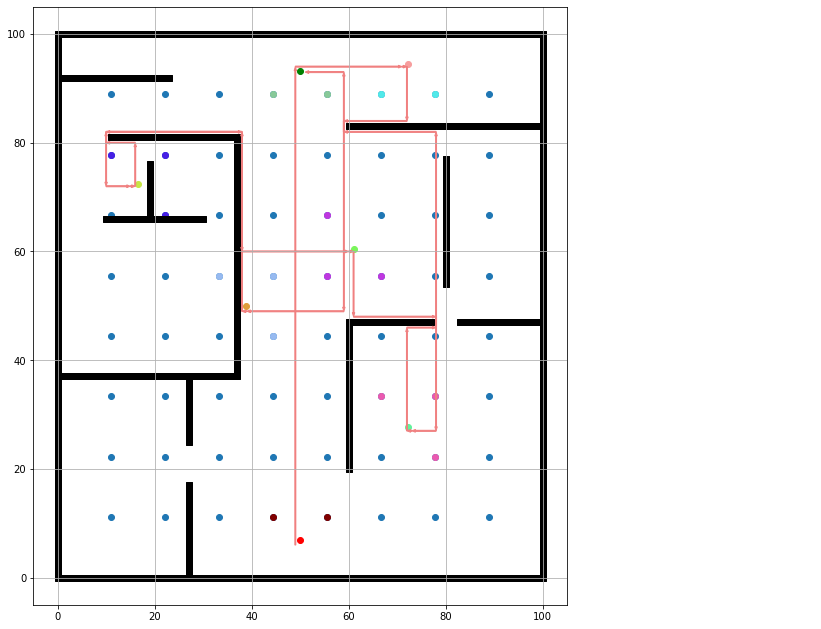

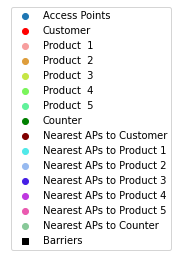


Full Simulation time: 3.501312017440796 seconds
Total iterations of A* algorithm used:   6
Algorithm total run time:   0.7447383403778076 seconds
Algorithm average run time:   0.1241230567296346 seconds
Original cost to reach goal:   512 steps
Total cost to reach goal:   32 steps
Total path length:   511
Total number of turns:   25
Current memory usage: 3.445161 MB
Peak memory usage: 5.503357 MB


In [24]:
# Finding amount of memory used by program
tracemalloc.start()

# Defining number of nodes in x and y axis as well as maximum board size
n_x=10
n_y=10
max_distance=100

mode=1

map_type=1

# Call the simulate function
access_points,all_rssi, all_near_aps, all_coordinate,all_distances, prod_num, path_og, paths, total_opt_path =simulate(n_x, n_y, max_distance, mode, map_type)

current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage: {current / 10**6} MB")
print(f"Peak memory usage: {peak / 10**6} MB")

tracemalloc.stop()

In [25]:
sim_file="simulation_results.txt"
print_sim_results(access_points, all_rssi, all_near_aps, all_coordinate, all_distances, prod_num, current, peak, sim_file)

Simulation Results:
------------------
Customer start coordinates:
    X: 49
    Y: 6
Product 1 coordinates:
    X: 72
    Y: 94
Product 2 coordinates:
    X: 38
    Y: 49
Product 3 coordinates:
    X: 16
    Y: 72
Product 4 coordinates:
    X: 61
    Y: 60
Product 5 coordinates:
    X: 72
    Y: 27
Counter coordinates:
    X: 50
    Y: 93
Customer nearest APs coordinates and Respective RSSI:
    AP 1: (55.55555555555556, 0.0)
    RSSI of AP 1: -31.63522019305991
    AP 2: (44.44444444444444, 11.11111111111111)
    RSSI of AP 2: -30
    AP 3: (55.55555555555556, 11.11111111111111)
    RSSI of AP 3: -30
Product 1 nearest APs coordinates and Respective RSSI:
    AP 1: (66.66666666666666, 88.88888888888889)
    RSSI of AP 1: -30
    AP 2: (66.66666666666666, 100.0)
    RSSI of AP 2: -30
    AP 3: (77.77777777777777, 88.88888888888889)
    RSSI of AP 3: -30
Product 2 nearest APs coordinates and Respective RSSI:
    AP 1: (33.33333333333333, 55.55555555555556)
    RSSI of AP 1: -30
    AP 2

In [26]:
# Function to save original path without node reduction to csv file
def export_path_to_csv(path, filename):
    df = pd.DataFrame(path, columns=['x', 'y'])
    df.to_csv(filename, index=False)

In [27]:
export_path_to_csv(path_og, 'path_og.csv')
export_path_to_csv(paths, 'paths_opt.csv')

In [28]:
# reading path from csv file and loading to a dataframe
df1 = pd.read_csv('path_og.csv')
df2 = pd.read_csv('paths_opt.csv')

In [29]:
# Convert DataFrame to list of tuples
path_data1 = list(df1.itertuples(index=False, name=None))
path_data2 = list(df2.itertuples(index=False, name=None))

In [30]:
# generating file containing array of coordinates and number of points for arduino
arduino_array1 = "const int pathData[][2] = {\n"
for x, y in path_data1:
    arduino_array1 += f"  {{{x}, {y}}},\n"
arduino_array1 = arduino_array1.strip()[:-1]  # Remove the last comma
arduino_array1 += "\n};\n"
arduino_array1 += f"const int numPoints = {len(path_data1)};\n"

arduino_array2 = "const int pathData[][2] = {\n"
for x, y in path_data2:
    arduino_array2 += f"  {{{x}, {y}}},\n"
arduino_array2 = arduino_array2.strip()[:-1]  # Remove the last comma
arduino_array2 += "\n};\n"
arduino_array2 += f"const int numPoints = {len(path_data2)};\n"

In [31]:
# Write the Arduino array code to a file
with open('path_data1.h', 'w') as f:
    f.write(arduino_array1)
    
with open('path_data2.h', 'w') as f:
    f.write(arduino_array2)